In [1]:
import sys
# append to path the folder that contains the analytic scanner
sys.path.append('../ESA/GaiaLab/gaialab')

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source
from source import Calc_source
import constants as const

import quaternion
import helpers as helpers
import numpy as np

import astropy.units as units
import matplotlib.pyplot as plt
import astropy.units as units

In [2]:
t_init = 0 
t_end =  365*5
my_dt = 1/24 # [days]
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)

In [3]:
class Calc_src :
    """the data structure that is used for a calculated source"""
    def __init__(self,alpha,delta,varpi,muAlphaStar,muDelta):
        self.s_params = [alpha,delta,varpi,muAlphaStar,muDelta]
        self.mu_radial = 0.0

the agis.py code is not that simple, basic functionalities such as source solver are not obvious, below is a proposal for changes.

In [4]:
def compute_du_ds(p,q,r,q_l,t_l):
    """
    params p,q,r : the vectors defining the frame associated to a source position at reference epoch
    params q_l,t_l : the attitude at time t_l
    returns : du_ds_SRS
    """
    # Equation 73
    r.shape = (3, 1)  # reshapes r
    b_G = gaia.ephemeris_bcrs(t_l)
    tau = t_l - const.t_ep  # + np.dot(r, b_G) / const.c
    # Compute derivatives
    du_ds_CoMRS = [p, q, af.compute_du_dparallax(r, b_G), p*tau, q*tau]
    # Equation 72
    # should be changed to a pythonic map
    du_ds_SRS = []
    for derivative in du_ds_CoMRS:
        du_ds_SRS.append(ft.lmn_to_xyz(q_l, derivative))
    return np.array(du_ds_SRS)

def compute_design_equation(true_source,calc_source,observation_times):
    """
    param true_source : the parameters of the true source
    param calc_source : the parameters of the estimated source
    param observation_times : a list of times that will be used to create observation 
        (they do not necessarly correspond to a realistic scanning law, 
        indeed the true attitude is taken using the position of the true source at these times)
    returns : dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA(phi_obs, zeta_obs,phi_calc, zeta_calc)
    """
    alpha0 = calc_source.s_params[0]
    delta0 = calc_source.s_params[1]    
    p, q, r = ft.compute_pqr(alpha0, delta0)
    n_obs = len(observation_times)
    R_AL = np.zeros(n_obs)
    R_AC = np.zeros(n_obs)
    dR_ds_AL = np.zeros((n_obs, 5))
    dR_ds_AC = np.zeros((n_obs, 5))
    FA = []
    for j, t_l in enumerate(observation_times): 
        # fake attitude using the position of the true sources at the given time
        # i.e. not based on the nominal scanning law
        q_l = af.attitude_from_alpha_delta(true_source,gaia,t_l,0)
        phi_obs, zeta_obs = af.observed_field_angles(true_source, q_l, gaia, t_l, False)
        phi_calc, zeta_calc = af.calculated_field_angles(calc_source, q_l, gaia, t_l, False)
        
        FA.append([phi_obs, zeta_obs,phi_calc, zeta_calc])
        
        R_AL[j] = (phi_obs-phi_calc)
        R_AC[j] = (zeta_obs-zeta_calc)
        
        m, n, u = af.compute_mnu(phi_calc, zeta_calc)
        
        du_ds = compute_du_ds(p,q,r,q_l,t_l)
        dR_ds_AL[j, :] = m @ du_ds.transpose() * helpers.sec(zeta_calc)
        dR_ds_AC[j, :] = n @ du_ds.transpose()
    return dR_ds_AL, dR_ds_AC, R_AL, R_AC, np.array(FA)

def solve_AL(true_source,calc_source,observation_times):
    """
    perform one step of the source solver using along scan observations
    """
    # get the design equation
    dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA = compute_design_equation(true_source,calc_source,my_observations)
    # build the normal equation
    N = dR_ds_AL.transpose() @ dR_ds_AL 
    rhs = dR_ds_AL.transpose() @ R_AL
    # solve the normal equation
    updates = np.linalg.solve(N,rhs)
    # update the calculated source parameters
    # take care of alpha
    calc_source.s_params[0] = calc_source.s_params[0] + updates[0] * np.cos(calc_source.s_params[1])
    calc_source.s_params[1:] = calc_source.s_params[1:] + updates[1:]

the source model might need some clarification

In [5]:
zero_color = lambda t: 0
sirio = Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, 0,0,0)

In [6]:
np.random.seed(seed=1)  # numpy seed set to increase reproducibility
my_observations = np.random.randint(low=t_init, high=t_end, size=100)
my_observations = np.sort(my_observations)

In [7]:
def noise_calc_sources(s,noise = 1e-5):
    """
    add noise to source parameters
    """
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/10
    s.s_params[3] += s.s_params[3]*0.1
    s.s_params[4] += s.s_params[4]*0.1

The mode updating set to 'source' means that one used a non realistic attitude for each observation time based on the source position. The documentation should be updated to be clearer.

In [8]:
calc_s =Calc_source(obs_times=my_observations, source=sirio)
noise_calc_sources(calc_s)
calc_s.s_params-sirio.get_parameters()[:5]

AttributeError: 'Calc_source' object has no attribute 's_params'

The field angles values computed in *compute_design_equation* can be used to visualised the source position in the sky as seen in the SRS reference frame associated to the satellite.

In [ ]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA = compute_design_equation(sirio,calc_s,my_observations)  

for the true source

In [ ]:
plt.scatter(FA[:,0]*units.rad.to(units.mas),FA[:,1]*units.rad.to(units.mas),c=my_observations)

for the current estimate of the calculated source

In [9]:
plt.scatter(FA[:,2]*units.rad.to(units.mas),FA[:,3]*units.rad.to(units.mas),c=my_observations)

NameError: name 'FA' is not defined

One can check that the solver is converging after 10 iterations of the source update.

In [12]:
for i in range(0,10):
    solve_AL(sirio,calc_s,my_observations)
    calc_s.s_params-sirio.get_parameters()[:5]

In [13]:
dR_ds_AL, dR_ds_AC, R_AL, R_AC, FA = compute_design_equation(sirio,calc_s,my_observations)  

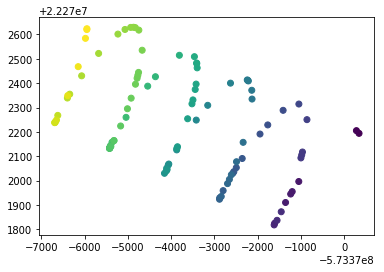

In [14]:
plt.scatter(FA[:,0]*units.rad.to(units.mas),FA[:,1]*units.rad.to(units.mas),c=my_observations)

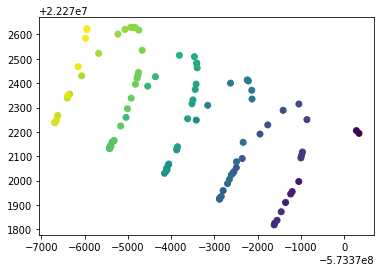

In [15]:
plt.scatter(FA[:,2]*units.rad.to(units.mas),FA[:,3]*units.rad.to(units.mas),c=my_observations)